# CAB420 Assignment 1A Question 2: Template
Simon Denman (s.denman@qut.edu.au)

## Overview

This notebook provides a brief template for CAB420 Assignment 1A, Question 2. It simply implements the data loading, and splitting the data into the predictors and response. You are to use the data splits defined here in your response.

**Note: File paths used in this template may need to change for your local machine. Please set these based on your local file system structure.**

Packages

In [1]:
# import important packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm

Setup

In [2]:
# load data
train = pd.read_csv('training.csv')
val = pd.read_csv('validation.csv')
test = pd.read_csv('testing.csv')

# pull out X and y data, convert to numpy
X_train = train.iloc[:,1:].to_numpy()
Y_train = train.iloc[:,0].to_numpy()
X_val = val.iloc[:,1:].to_numpy()
Y_val = val.iloc[:,0].to_numpy()
X_test = test.iloc[:,1:].to_numpy()
Y_test = test.iloc[:,0].to_numpy()

Important functions

In [3]:
# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - get precision, recall, f1 for test data
# this has simply been created as we're going to do this for each test that we run
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance: %1.3f' % (sum(model.predict(X_train) == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    conf.ax_.set_title('Testing Set Performance: %1.3f' % (sum(model.predict(X_test) == Y_test)/len(Y_test)));
    print(classification_report(Y_test, model.predict(X_test)))

Standardising data

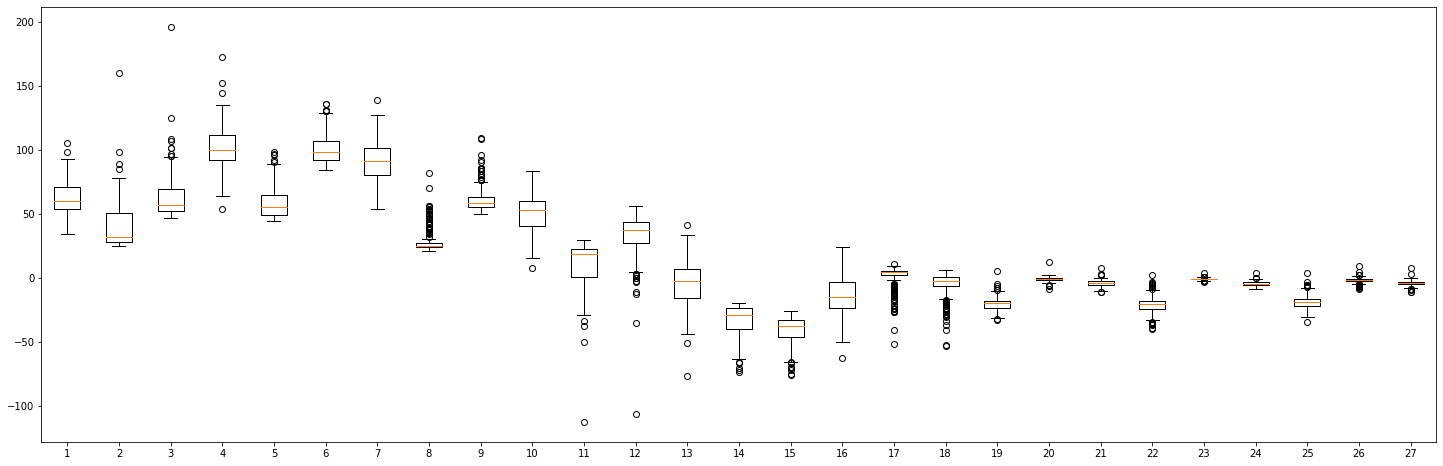

In [4]:
# visualising data
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(X_train);

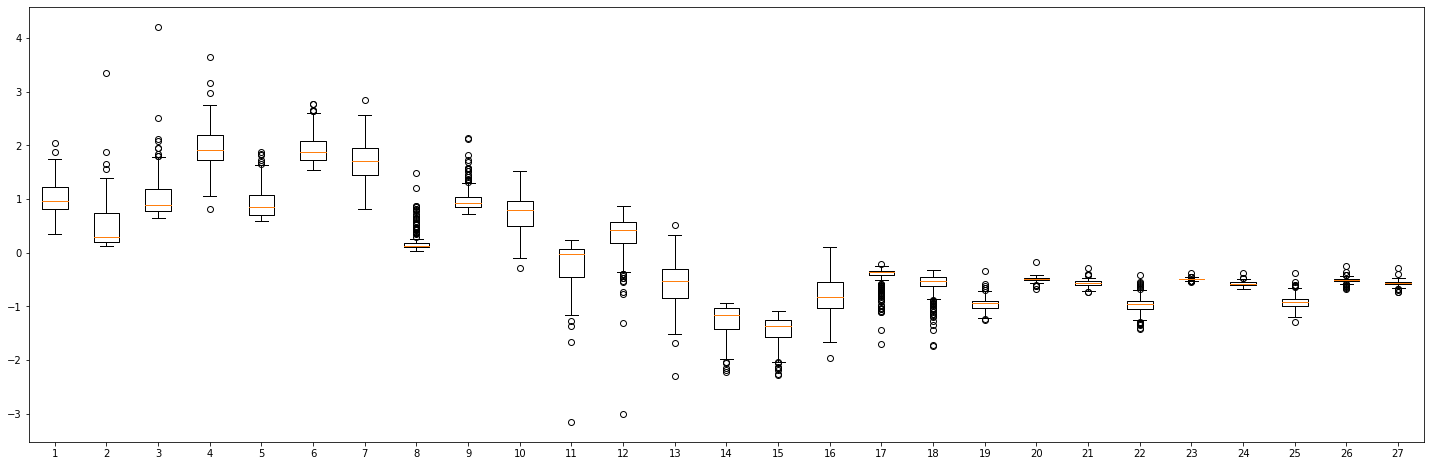

In [5]:
mu = np.mean(X_train)
sigma = np.std(X_train)
X_train = (X_train - mu) / sigma;
X_test = (X_test - mu) / sigma;
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(X_train);

Class imbalance

Text(0.5, 1.0, 'Test data set')

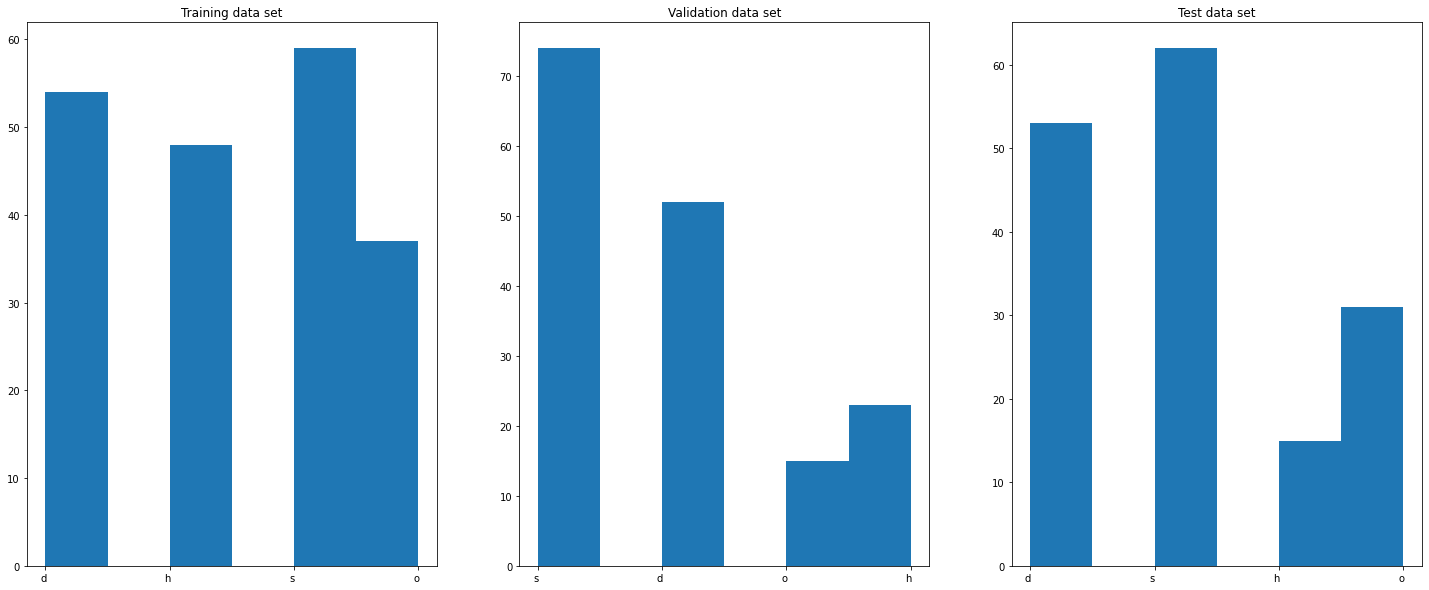

In [6]:
# having a look at class imbalance
fig = plt.figure(figsize=[25, 10])
ax = fig.add_subplot(1, 3, 1)
ax.hist(Y_train, 6)
ax.set_title('Training data set')
ax = fig.add_subplot(1, 3, 2)
ax.hist(Y_val, 6)
ax.set_title('Validation data set')
ax = fig.add_subplot(1, 3, 3)
ax.hist(Y_test, 6)
ax.set_title('Test data set')

CKNN

              precision    recall  f1-score   support

          d        0.85      0.89      0.87        53
          h        0.67      0.93      0.78        15
          o        0.96      0.71      0.81        31
          s        0.89      0.89      0.89        62

    accuracy                           0.86       161
   macro avg       0.84      0.85      0.84       161
weighted avg       0.87      0.86      0.86       161



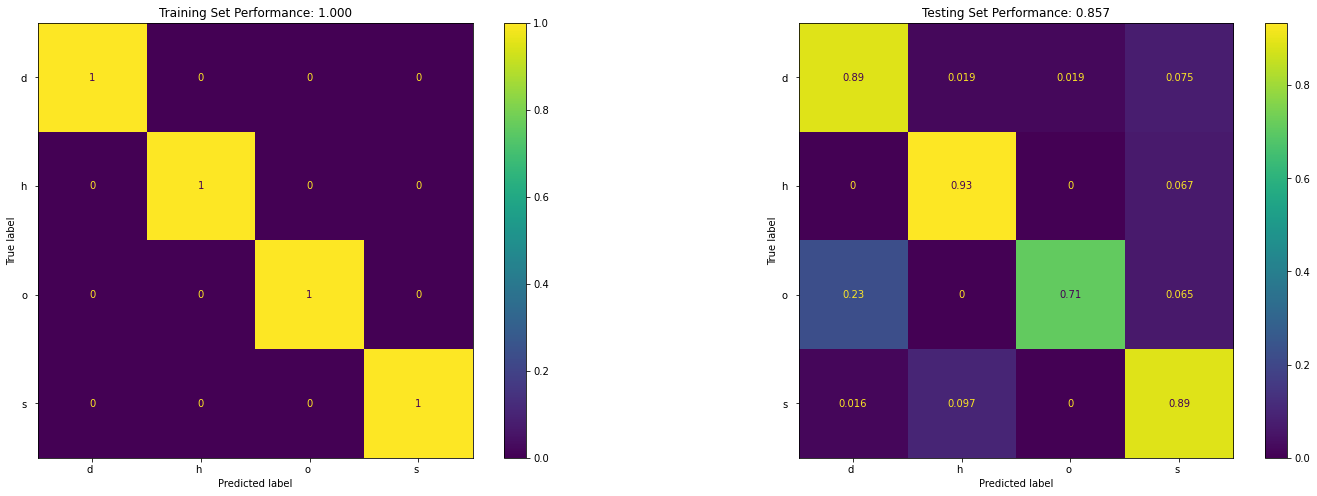

In [7]:
# cknn = KNeighborsClassifier(n_neighbors=20)
# cknn.fit(X_train, Y_train)
# eval_model(cknn, X_train, Y_train, X_test, Y_test)

neighbours = [1, 2, 4, 8, 16, 32, 64]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan']
best_acc = 0
best_model = None
for k in neighbours:
    for w in weights:
        for m in metric:
            cknn = KNeighborsClassifier(n_neighbors=k, weights=w, metric=m).fit(X_train, Y_train)            
            acc = f1_score(Y_val, cknn.predict(X_val), average='macro')
            if (acc > best_acc):
                best_acc = acc
                best_model = cknn
                eval_model(best_model, X_train, Y_train, X_test, Y_test)


Random Forests

              precision    recall  f1-score   support

          d        0.82      0.75      0.78        53
          h        0.75      0.80      0.77        15
          o        0.96      0.77      0.86        31
          s        0.77      0.89      0.83        62

    accuracy                           0.81       161
   macro avg       0.83      0.80      0.81       161
weighted avg       0.82      0.81      0.81       161

0.09561234329797494


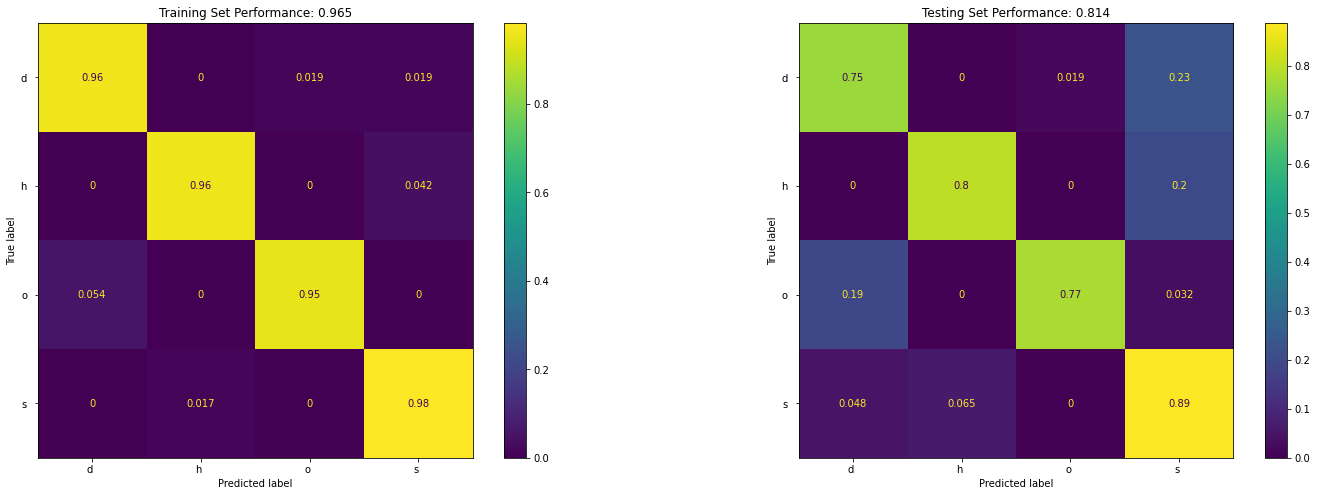

In [8]:

estimators = [100]
depth = [1]
for d in depth:
    for e in estimators:
        rf = RandomForestClassifier(n_estimators=e, max_depth=d, random_state=0).fit(X_train, Y_train)
        eval_model(rf, X_train, Y_train, X_test, Y_test)

        acc = f1_score(Y_val, rf.predict(X_val), average='macro')
        print(acc)



SVM

              precision    recall  f1-score   support

          d        0.86      0.70      0.77        53
          h        0.64      0.93      0.76        15
          o        0.96      0.71      0.81        31
          s        0.75      0.89      0.81        62

    accuracy                           0.80       161
   macro avg       0.80      0.81      0.79       161
weighted avg       0.82      0.80      0.79       161



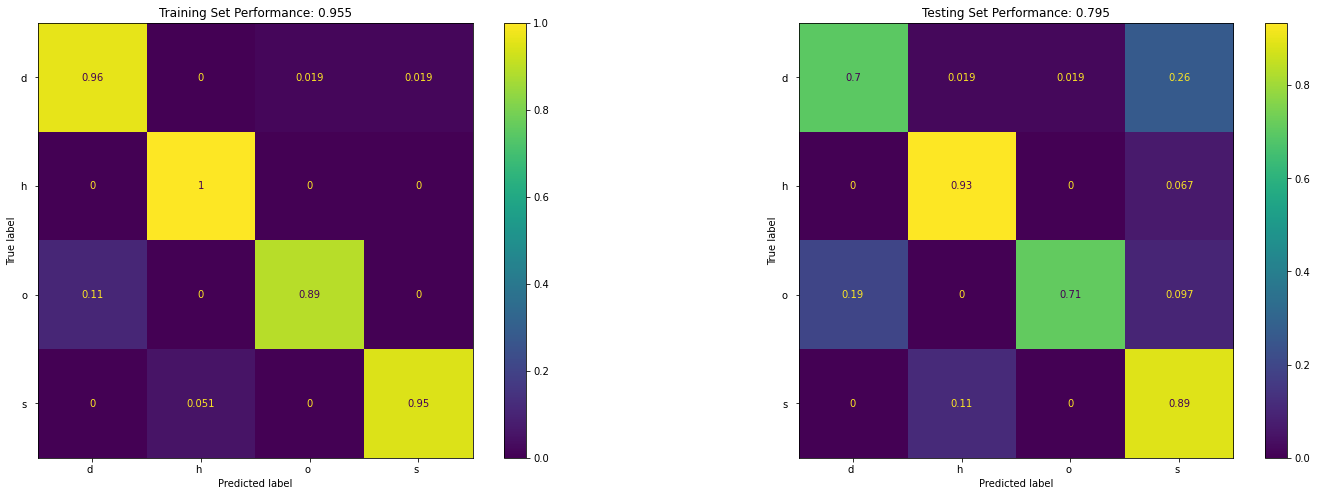

In [9]:
svm = SVC()
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)

perform grid search

In [10]:
param_grid = [
  {'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100], 'degree': [3, 4, 5], 'kernel': ['poly']},
 ]
svm = SVC(class_weight='balanced')
grid_search = GridSearchCV(svm, param_grid)
grid_search.fit(X_val, Y_val)
grid_search.cv_results_

{'mean_fit_time': array([0.00865045, 0.01668987, 0.02569451, 0.11406064, 0.00308175,
        0.00270886, 0.00270228, 0.00329328, 0.00299802, 0.00217772,
        0.00370231, 0.0031836 , 0.00214419, 0.00396948, 0.0033175 ,
        0.00228581, 0.00256763, 0.00235882, 0.00270691, 0.00224724,
        0.00178452, 0.00208931, 0.00180521, 0.00192351, 0.00228138,
        0.002356  , 0.00289068, 0.00289884]),
 'std_fit_time': array([5.18361422e-03, 8.13280546e-03, 1.76946264e-02, 1.60469047e-01,
        1.95663224e-04, 1.36878961e-04, 1.05494701e-04, 1.31321248e-04,
        1.50964009e-04, 8.54458393e-05, 3.21589833e-04, 4.71891432e-04,
        8.90156256e-05, 6.67678780e-04, 9.47389488e-04, 3.48314468e-04,
        3.89924430e-04, 4.45466944e-04, 8.52122526e-04, 5.94288936e-04,
        3.67973106e-05, 6.68000567e-04, 1.56861713e-04, 2.52143915e-04,
        6.35957834e-04, 4.77073501e-04, 8.47288760e-04, 7.65910260e-04]),
 'mean_score_time': array([0.00114899, 0.00067616, 0.0006917 , 0.00067616, 

{'C': 100, 'degree': 4, 'kernel': 'poly'}
hell
              precision    recall  f1-score   support

          d        0.86      0.81      0.83        53
          h        0.60      0.80      0.69        15
          o        0.89      0.77      0.83        31
          s        0.84      0.87      0.86        62

    accuracy                           0.83       161
   macro avg       0.80      0.81      0.80       161
weighted avg       0.84      0.83      0.83       161



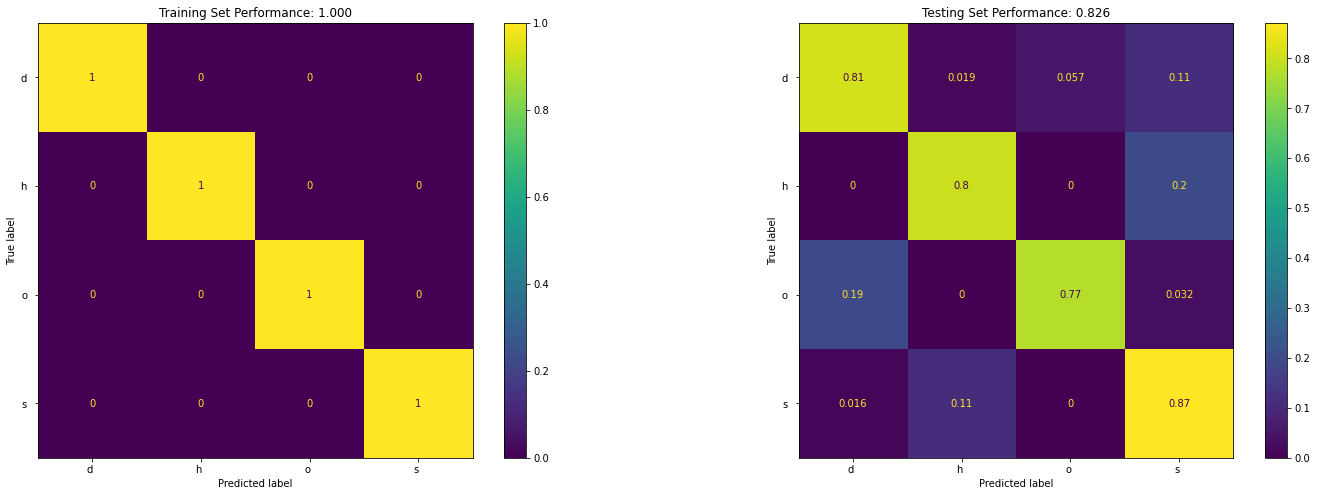

In [11]:
best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)
print("hell")
svm = SVC().set_params(**params)
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)